In [19]:
# STEP 1: Install XGBoost if not already installed
!pip install xgboost -q

📈 Train Accuracy: 0.99
✅ Test Accuracy: 0.80

📊 Classification Report:
                  precision    recall  f1-score   support

DroughtResistant       0.79      0.85      0.81        13
      FastGrower       0.73      0.79      0.76        14
        Hardwood       0.77      0.71      0.74        14
        Mangrove       1.00      1.00      1.00        14
       Medicinal       0.83      0.71      0.77        14
       ShadeTree       0.67      0.71      0.69        14

        accuracy                           0.80        83
       macro avg       0.80      0.80      0.80        83
    weighted avg       0.80      0.80      0.80        83



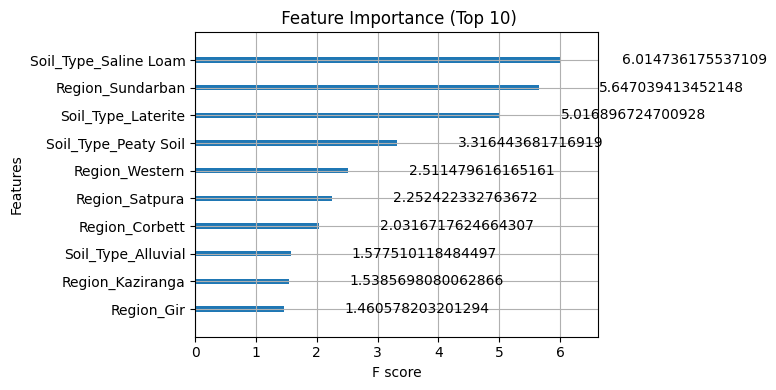

In [23]:
# STEP 2: Imports
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report
import joblib
import matplotlib.pyplot as plt

# STEP 3: Load dataset
df = pd.read_csv("smart_replanting_dataset.csv")
X = df.drop(columns=["Label", "Grouped_Label"])
y = df["Grouped_Label"]

# Encode categorical features
X_encoded = pd.get_dummies(X, columns=["Region", "Soil_Type"])

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
df_encoded = pd.DataFrame(X_encoded)
df_encoded["Target"] = y_encoded

# STEP 4: Upsample each class
max_count = df_encoded["Target"].value_counts().max()
upsampled = [
    group.sample(max_count, replace=True, random_state=42)
    for _, group in df_encoded.groupby("Target")
]
df_bal = pd.concat(upsampled)

X_bal = df_bal.drop("Target", axis=1)
y_bal = df_bal["Target"]

# STEP 5: Scale features
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(X_scaled, columns=X_bal.columns)

# STEP 6: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# STEP 7: Train XGBoost model with early stopping
model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_bal)),
    eval_metric="mlogloss",
    learning_rate=0.05,
    max_depth=4,
    n_estimators=170,
    subsample=0.8,            # Only use 80% of rows per tree
    colsample_bytree=0.8,     # Only use 80% of features per tree
    random_state=42
)

model.fit(X_train, y_train)


# STEP 8: Evaluate
y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
train_acc = accuracy_score(y_train, model.predict(X_train))

print(f"📈 Train Accuracy: {train_acc:.2f}")
print(f"✅ Test Accuracy: {test_acc:.2f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# STEP 10: Save model & artifacts
joblib.dump(model, "xgb_model.pkl")
joblib.dump(scaler, "xgb_scaler.pkl")
joblib.dump(le, "xgb_label_encoder.pkl")
joblib.dump(X_bal.columns.tolist(), "xgb_feature_columns.pkl")
joblib.dump({"model": "XGBoost", "train_accuracy": train_acc, "test_accuracy": test_acc}, "xgb_metrics.pkl")

fig, ax = plt.subplots(figsize=(8,4))
xgb.plot_importance(model, importance_type='gain', max_num_features=10, ax=ax)
plt.title(" Feature Importance (Top 10)")
plt.tight_layout()
plt.savefig("xgb_feature_importance.png")

